# PBO learnt on several iterations

## Define paramters

In [1]:
%load_ext autoreload
%autoreload 2

import jax

# keys
seed = 1
key = jax.random.PRNGKey(seed)
env_key, key = jax.random.split(key)
shuffle_key, q_network_key, random_weights_key, pbo_network_key = jax.random.split(key, 4)

# Box over states and actions
max_discrete_state = 5
n_discrete_states = 7
max_discrete_action = 5
n_discrete_actions = 7

# Weights collection
n_weights = 100
filtering_weights = True

# Q function
layers_dimension = [50]
action_range_on_max = max_discrete_action
n_actions_on_max = 50

# PBO trainings
tolerance = 0.1
max_iterations = 1000
batch_size_samples = 20
batch_size_weights = n_weights
learning_rate = {"first": 0.001, "last": 0.0005, "duration": max_iterations}
max_bellman_iterations = 5

# Visualisation
plot_freq = 20
sleeping_time = 0

## Define environment

In [2]:
import numpy as np

from pbo.environment.linear_quadratic import LinearQuadraticEnv


discrete_states = np.linspace(-max_discrete_state, max_discrete_state, n_discrete_states)
state_box_half_size = max_discrete_state / n_discrete_states
discrete_states_boxes = np.linspace(
    -max_discrete_state - state_box_half_size, max_discrete_state + state_box_half_size, n_discrete_states + 1
)

discrete_actions = np.linspace(-max_discrete_action, max_discrete_action, n_discrete_actions)
action_box_half_size = max_discrete_action / n_discrete_actions
discrete_actions_boxes = np.linspace(
    -max_discrete_action - action_box_half_size, max_discrete_action + action_box_half_size, n_discrete_actions + 1
)

env = LinearQuadraticEnv(env_key, max_init_state=max_discrete_state)

Transition: s' = As + Ba
Transition: s' = -0.10490131378173828s + -0.6472394466400146a
Reward: Qs² + Ra² + 2 Ssa
Reward: -0.21946656703948975s² + -0.19231724739074707a² + -0.11510777473449707sa


## Collect samples

### Samples on the mesh

In [3]:
import jax.numpy as jnp

from pbo.sample_collection.replay_buffer import ReplayBuffer


n_samples = n_discrete_states * n_discrete_actions
replay_buffer = ReplayBuffer()

for state in discrete_states:
    for action in discrete_actions:
        env.reset(jnp.array([state]))
        next_state, reward, _, _ = env.step(jnp.array([action]))

        replay_buffer.add(jnp.array([state]), jnp.array([action]), reward, next_state)

replay_buffer.cast_to_jax_array()

### Visualize samples

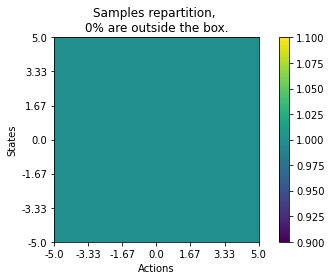

In [4]:
from pbo.sample_collection.count_samples import count_samples
from pbo.utils.state_action_mesh import StateActionMesh


samples_count, n_outside_boxes = count_samples(replay_buffer, discrete_states_boxes, discrete_actions_boxes)
samples_visu_mesh = StateActionMesh(discrete_states, discrete_actions, sleeping_time=0)

samples_visu_mesh.set_values(samples_count, zeros_to_nan=True)
samples_visu_mesh.show(
    f"Samples repartition, \n{int(100 * n_outside_boxes / n_samples)}% are outside the box."
)


## Optimal Q function

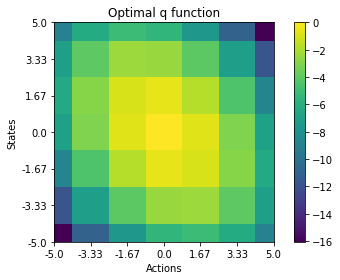

In [5]:
optimal_q = env.optimal_Q_mesh(discrete_states, discrete_actions)

q_visu_mesh = StateActionMesh(discrete_states, discrete_actions, sleeping_time)

q_visu_mesh.set_values(optimal_q)
q_visu_mesh.show("Optimal q function")

## Build q network

In [6]:
from pbo.networks.q import FullyConnectedQ


q = FullyConnectedQ(
    layers_dimension=layers_dimension,
    network_key=q_network_key,
    random_weights_range=None,
    random_weights_key=random_weights_key,
    action_range_on_max=action_range_on_max,
    n_actions_on_max=n_actions_on_max,
)

## Collect weigths

### Random init weights

In [7]:
from pbo.weights_collection.weights_buffer import WeightsBuffer   

def good_weights(key, weights):
    random_state = jnp.array([jax.random.uniform(key, minval=-max_discrete_state, maxval=max_discrete_state)])

    discrete_actions_on_max = jnp.linspace(
        -action_range_on_max, action_range_on_max, num=n_actions_on_max
    ).reshape((-1, 1))

    q_values = q.network.apply(
        q.to_params(weights), random_state.repeat(len(discrete_actions_on_max)).reshape((-1, 1)), discrete_actions_on_max
    )

    return jnp.abs(discrete_actions_on_max[q_values.argmax()]) < 3 * action_range_on_max / 4 


weights_buffer = WeightsBuffer()
random_weights_filtering_key, key = jax.random.split(random_weights_key)

while len(weights_buffer) < n_weights:
    weights = q.random_init_weights()
    random_weights_filtering_key, key = jax.random.split(random_weights_filtering_key)
    if not filtering_weights or good_weights(key, weights):
        weights_buffer.add(weights)

weights_buffer.cast_to_jax_array()

## Build PBO network and its dataloaders

In [8]:
from pbo.networks.pbo import LinearPBO
from pbo.sample_collection.dataloader import SampleDataLoader
from pbo.weights_collection.dataloader import WeightsDataLoader

data_loader_samples = SampleDataLoader(replay_buffer, batch_size_samples, shuffle_key)
data_loader_weights = WeightsDataLoader(weights_buffer, batch_size_weights, shuffle_key)

pbo = LinearPBO(pbo_network_key, q, learning_rate, max_bellman_iterations)

## Train PBO on several iterations

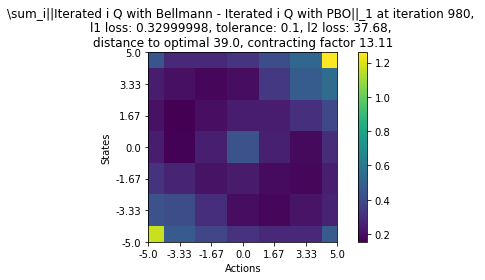

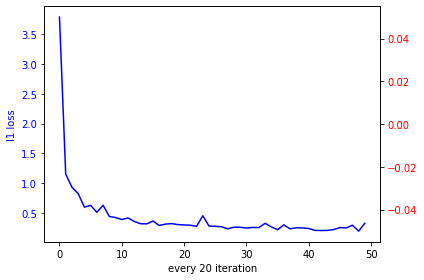

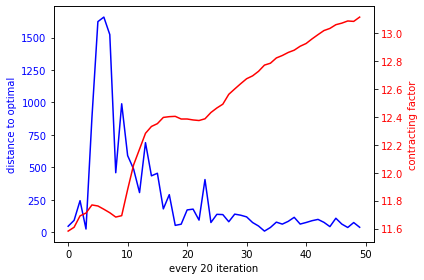

In [9]:
from pbo.utils.shared_axis_plot import shared_axis_plot


# For visualization
full_batch = {
    "state": replay_buffer.states,
    "action": replay_buffer.actions,
    "reward": replay_buffer.rewards,
    "next_state": replay_buffer.next_states,
}
l1_losses = []
optimal_distances = []
contractings = []

iteration = 0
l1_loss = float("inf")

while l1_loss > tolerance and iteration < max_iterations:
    cumulative_l2_loss = 0
    
    data_loader_weights.shuffle()
    for batch_weights in data_loader_weights:
        data_loader_samples.shuffle()
        for batch_samples in data_loader_samples:
            pbo.params, pbo.optimizer_state, l2_loss = pbo.learn_on_batch(pbo.params, pbo.optimizer_state, batch_weights, batch_samples)
            cumulative_l2_loss += l2_loss

    # Visualization
    if iteration % plot_freq == 0:
        discrete_fixed_point_q = q.discretize(pbo.fixed_point().reshape((1, -1)), discrete_states, discrete_actions)[0]
        optimal_distance = jnp.linalg.norm(optimal_q - discrete_fixed_point_q)
        contracting = pbo.contracting_factor()

        l1_loss_mesh = pbo.l1_loss_mesh(pbo.params, data_loader_weights.weights, full_batch, n_discrete_states, n_discrete_actions)
        l1_loss = l1_loss_mesh.mean()

        q_visu_mesh.set_values(l1_loss_mesh)
        q_visu_mesh.show(f"\sum_i||Iterated i Q with Bellmann - Iterated i Q with PBO||_1 at iteration {iteration}, \nl1 loss: {str(np.round(l1_loss, 2))}, tolerance: {tolerance}, l2 loss: {str(np.round(cumulative_l2_loss, 2))}, \ndistance to optimal {str(np.around(optimal_distance, 2))}, contracting factor {str(np.around(contracting, 2))}")

        l1_losses.append(l1_loss)
        optimal_distances.append(optimal_distance)
        contractings.append(contracting)

    iteration += 1


shared_axis_plot(l1_losses, np.nan * np.array(l1_losses), f"every {plot_freq} iteration", "l1 loss")
shared_axis_plot(optimal_distances, contractings, f"every {plot_freq} iteration", "distance to optimal", "contracting factor")

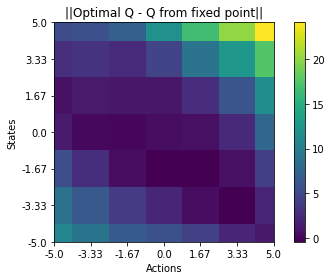

In [10]:
discrete_fixed_point_q = q.discretize(pbo.fixed_point().reshape((1, -1)), discrete_states, discrete_actions)[0]

q_visu_mesh.set_values(optimal_q - discrete_fixed_point_q)
q_visu_mesh.show("||Optimal Q - Q from fixed point||")

## Validation

### on weights

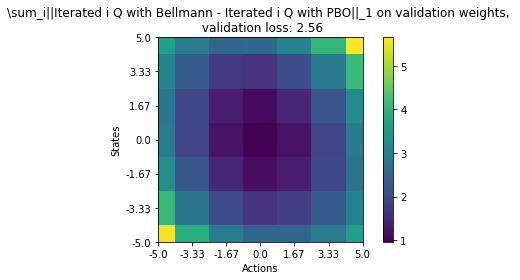

In [12]:
n_weights_val = 500
weights_buffer_val = WeightsBuffer()

while len(weights_buffer_val) < n_weights_val:
    weights = q.random_init_weights()
    weights_buffer_val.add(weights)

weights_buffer_val.cast_to_jax_array()

l1_loss_mesh = pbo.l1_loss_mesh(pbo.params, weights_buffer_val.weights, full_batch, n_discrete_states, n_discrete_actions)
l1_loss = l1_loss_mesh.mean()

q_visu_mesh.set_values(l1_loss_mesh)
q_visu_mesh.show(f"\sum_i||Iterated i Q with Bellmann - Iterated i Q with PBO||_1 on validation weights, \n validation loss: {str(np.round(l1_loss, 2))}")

### on samples

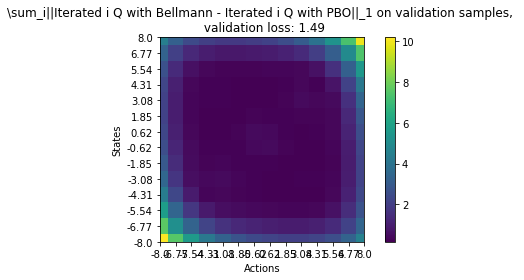

In [13]:
n_discrete_states_val = 2 * n_discrete_states
n_discrete_actions_val = 2 * n_discrete_actions
discrete_states_val = np.linspace(-max_discrete_state - 3, max_discrete_state + 3, n_discrete_states_val)
discrete_actions_val = np.linspace(-max_discrete_action - 3 , max_discrete_action + 3, n_discrete_actions_val)

n_samples = n_discrete_states_val * n_discrete_actions_val
replay_buffer_val = ReplayBuffer()

for state in discrete_states_val:
    for action in discrete_actions_val:
        env.reset(jnp.array([state]))
        next_state, reward, _, _ = env.step(jnp.array([action]))

        replay_buffer_val.add(jnp.array([state]), jnp.array([action]), reward, next_state)

replay_buffer_val.cast_to_jax_array()

q_visu_mesh_val = StateActionMesh(discrete_states_val, discrete_actions_val, sleeping_time)        

full_batch_val = {
    "state": replay_buffer_val.states,
    "action": replay_buffer_val.actions,
    "reward": replay_buffer_val.rewards,
    "next_state": replay_buffer_val.next_states,
}

l1_loss_mesh = pbo.l1_loss_mesh(pbo.params, weights_buffer.weights, full_batch_val, n_discrete_states_val, n_discrete_actions_val)
l1_loss = l1_loss_mesh.mean()

q_visu_mesh_val.set_values(l1_loss_mesh)
q_visu_mesh_val.show(f"\sum_i||Iterated i Q with Bellmann - Iterated i Q with PBO||_1 on validation samples, \n validation loss: {str(np.round(l1_loss, 2))}")